# Playrix Тестовое задание 1

## Подготовка данных

In [1]:
%pylab inline

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


Преобразуем в pandas dataframe файл с данными о продуктах: объединим две таблицы с семенами и промышленными товарами в одну, записав вид товара в отдельном столбце kind.

In [2]:
f = open('product_info.csv')

parsed = [filter(lambda x: x!='', line.decode('cp1251').rstrip().split('\t')) for line in f]
data = []

columns_dict = {
    u'id_product': 'product',
    u'Время производства(мин)': 'production_time',
    u'Время роста(мин)': 'production_time',
    u'Название': 'name',
    u'Стоимость покупки за кэш': 'price_to_buy',
    u'Стоимость продажи из амбара': 'price_to_sell',
    u'Уровень ввода': 'introduction_level'
}

for line in parsed:
    if len(line) == 1:
        kind = line[0]
        start = True
    elif len(line) > 1:
        if start:
            keys = ['kind'] + map(lambda x: columns_dict.get(x), line)
            start = False
        else:
            values = [kind] + line
            data.append({k: v for k, v in zip(keys, values)})
            
f.close()
            
products = pd.DataFrame(data)

for col in ['introduction_level', 'price_to_buy', 'price_to_sell', 'production_time']:
    products[col] = products[col].astype(int)

Просмотрим первые строки получившейся таблицы.

In [3]:
products.head()

,introduction_level,kind,name,price_to_buy,price_to_sell,product,production_time
0,1,Семена,Пшеница,1,1,wheat,2
1,3,Семена,Кукуруза,1,3,corn,5
2,4,Семена,Морковь,2,5,carrot,10
3,6,Семена,Тыква,3,6,pumpkin,25
4,7,Семена,Тростник,3,7,sugarcane,20


Преобразуем в pandas dataframe файл  с данными по удаленным заказам: запишем в таблицу только те продукты, по которым были удаленные заказы, пустые ячейки обрабатывать не будем. 

In [4]:
data = []

f = open('refused_order_products.csv')

for i, line in enumerate(f):
    line = line.rstrip().split(',')
    if i%3 == 0:
        products_ = filter(lambda x: x!='', [s.replace('Refused [','').replace(']','') for s in line][1:])
    elif i%3 == 1:
        orders = map(int, filter(lambda x: x!='', line[1:]))
        lvl = line[0]
        
        data.extend([{'level': lvl, 'product': p, 'orders': o} for p, o in zip(products_, orders)])
        
f.close()

df = pd.DataFrame(data)

Просмотрим первые строки получившейся таблицы.

In [5]:
df.head()

,level,orders,product
0,10-12,26584,wool
1,10-12,25804,woolfabric
2,10-12,22175,corn
3,10-12,21901,carrot
4,10-12,21218,sugarcane


Теперь дополним эту таблицу информацией о продуктах, которые уже были доступны, но по которым удаленных заказов не было: в этом случае запишем 0. Для этого составим полное декартово произведение продуктов и уровней products_levels, оставим только продукты, которые уже были доступны, и соединим полученную таблицу с таблицей df.

In [6]:
levels = df.level.unique().tolist()
levels = pd.DataFrame(
    [{'level': l, 'upper_bound': u, 'key': 'key'} for l, u in zip(levels, map(lambda x: int(x.split('-')[1]), levels))]
)

products_levels = products.loc[:, ['product', 'introduction_level']]
products_levels.loc[:, 'key'] = 'key'
products_levels = products_levels.merge(levels, on='key')
products_levels.drop('key', 1, inplace=True)

products_levels = products_levels[products_levels.introduction_level <= products_levels.upper_bound]
products_levels.head()

,product,introduction_level,level,upper_bound
0,wheat,1,10-12,12
1,wheat,1,13-15,15
2,wheat,1,16-19,19
3,wheat,1,20-23,23
4,wheat,1,24-28,28


In [7]:
df = products_levels.merge(df, how='left', on=['product', 'level']).fillna(0)
df = df[['product', 'level', 'orders']]
df.head()

,product,level,orders
0,wheat,10-12,19202.0
1,wheat,13-15,21255.0
2,wheat,16-19,38051.0
3,wheat,20-23,40604.0
4,wheat,24-28,39953.0


Теперь у нас есть полный набор данных с информацией о числе удаленных заказов по всем доступным на каждом уровне продуктам.

## Построение рейтинга продуктов по частоте удаления

Посмотрим, как менялось число продуктов в удаленных заказах (product, count), общее число удаленных заказов (orders, sum) и среднее число удаленных заказов на один продукт (orders, mean) в зависимости от уровня.

In [8]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'axes.grid': True}
pylab.rcParams.update(params)

In [9]:
pd.set_option('display.precision', 3)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10946b310>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x111bb1ad0>], dtype=object)

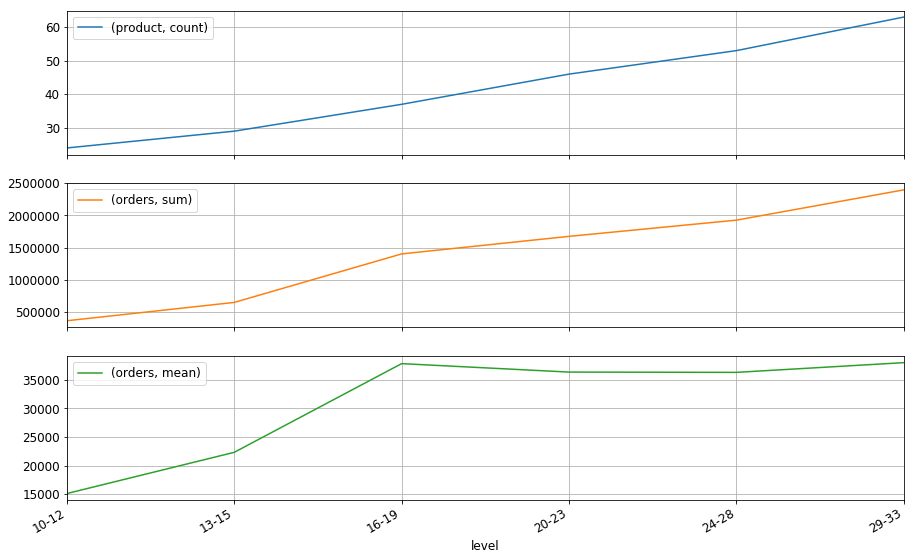

In [10]:
df.groupby('level').agg({'orders': ['sum', 'mean'], 'product': 'count'}).plot(subplots=True)

Видим, что число удаленных заказов постоянно растет с ростом уровня, растет и среднее число удаленных заказов на один продукт. По всей видимости, с ростом уровня игрок может выполнять все больше заказов. Поэтому абсолютные числа удаленных заказов для построения рейтинга наиболее часто удаляемых продуктов использовать нельзя, перейдем к относительным показателям: среднему рангу avg_rank, средней доле от общего числа удаленных заказов по уровням avg_share, среднему отношению числа удаленных заказов с данным продуктом к среднему числу удаленных заказов на продукт на данном уровне avg_normed.

Посчитаем для каждой группы уровней доли продуктов в общем числе удаленных заказов.

In [11]:
shares = df.groupby(['level', 'product']).orders.sum().groupby(level=0).apply(lambda x: x / float(x.sum()))
shares = shares.reset_index()
shares.columns = ['level', 'product', 'share']
shares.head()

,level,product,share
0,10-12,bagel,0.052
1,10-12,bread,0.057
2,10-12,butter,0.042
3,10-12,carrot,0.060
4,10-12,cheese,0.053


Теперь для каждого продукта посчитаем среднюю долю по всем группам уровней avg_share. Затем выведем топ-10 удаляемых продуктов по этой метрике: в данном случае в числе лидеров шерсть, резина, попкорн, шерстяная ткань и морковь.

In [12]:
avg_shares = shares.groupby('product').share.mean().reset_index()
avg_shares.columns = ['product', 'avg_share']
avg_shares.sort_values(by='avg_share', ascending=False, inplace=True)
avg_shares = avg_shares.reset_index(drop=True)
avg_shares.head(10)

,product,avg_share
0,wool,0.043
1,rubber,0.041
2,popcorn,0.040
3,woolfabric,0.037
4,carrot,0.035
5,shirt,0.035
6,bread,0.035
7,egg,0.035
8,paper,0.035
9,cream,0.034


Попробуем построить топ-10 по другой относительной метрике - среднему рангу.

In [13]:
ranks = df.groupby(['level', 'product']).orders.sum().groupby(level=0).rank(ascending=False)
ranks = ranks.reset_index()
ranks.columns = ['level', 'product', 'rank']
ranks.head()

,level,product,rank
0,10-12,bagel,12.0
1,10-12,bread,7.0
2,10-12,butter,18.0
3,10-12,carrot,4.0
4,10-12,cheese,10.0


In [14]:
avg_ranks = ranks.groupby('product')['rank'].mean().reset_index()
avg_ranks.columns = ['product', 'avg_rank']
avg_ranks.sort_values(by='avg_rank', ascending=True, inplace=True)
avg_ranks = avg_ranks.reset_index(drop=True)
avg_ranks.head(10)

,product,avg_rank
0,rubber,1.000
1,paper,3.000
2,wool,3.167
3,caramel,4.500
4,popcorn,5.600
5,carrot,7.667
6,muffin,10.500
7,cornchips,11.500
8,corn,11.667
9,milkshake,11.750


По этому показателю лидерами оказались резина, бумага, шерсть, карамель и попкорн.

Наконец, построим рейтинг по третьей метрике: нормируем число удаленных заказов на среднее по группе уровней, и потом посчитаем по полученным значениям среднее.

In [15]:
normed = df.groupby(['level', 'product']).orders.sum().groupby(level=0).apply(lambda x: x / float(x.mean()))
normed = normed.reset_index()
normed.columns = ['level', 'product', 'normed']
normed.head()

,level,product,normed
0,10-12,bagel,1.248
1,10-12,bread,1.358
2,10-12,butter,1.015
3,10-12,carrot,1.451
4,10-12,cheese,1.278


In [16]:
avg_normed = normed.groupby('product')['normed'].mean().reset_index()
avg_normed.columns = ['product', 'avg_normed']
avg_normed.sort_values(by='avg_normed', ascending=False, inplace=True)
avg_normed = avg_normed.reset_index(drop=True)
avg_normed.head(10)

,product,avg_normed
0,rubber,2.584
1,muffin,1.747
2,paper,1.634
3,popcorn,1.595
4,wool,1.578
5,milkshake,1.474
6,icecream,1.465
7,caramel,1.407
8,carrot,1.348
9,shirt,1.305


По данной метрике лидер снова резина, также в топ-5 попали маффин, бумага, попкорн и шерсть.

В условиях данной задачи наиболее правильной для построения рейтинга мне кажется третья метрика. 

На низких уровнях доступных продуктов еще немного, поэтому получить высокую долю легче. В результате по этой метрике в лидеры вырывается топовый продукт первой группы уровней - шерсть.

Средний ранг не позволяет адекватно оценить близкие, но разные значения: в данных часто встречаются случаи, когда число удаленных заказов по ряду продуктов на данном уровне примерно одинаковое, при этом ранг они получают разный. Например, на уровне 13-15 шерстяная ткань имеет 33 658 удаленных заказов, хлеб 33 065, сахар 32 890, яйца 32 795. Числа очень близкие, при этом ранги у них будут 4,5,6,7, то есть, будут различаться почти в 2 раза, при этом порядок получается в значительной степени случайным.

Последняя метрика лишена описанных выше недостатков.

## Выявление причин удаления продуктов: статистическое моделирование

Так как нам необходимо не предсказать частоту удаления продуктов, а выявить причины частого удаления, законы, связывающие между собой показатели, вместо методов машинного обучения мы будем использовать методы статистического (или эконометрического) моделирования.

Мы будем пытаться объяснить значения рассчитанных выше метрик, характеризующих частоту удаления заказов с данным продуктом, параметрами продуктов, записанными в таблице products.

Построим матрицу парных корреляций для количественных признаков. Если корреляция какой-то пары будет слишком высокой (более 0.9), один из признаков в паре избыточен. В данном случае такого не наблюдается.

In [17]:
products[['introduction_level', 'price_to_buy', 'price_to_sell', 'production_time']].corr()

,introduction_level,price_to_buy,price_to_sell,production_time
introduction_level,1.000,0.738,0.638,0.354
price_to_buy,0.738,1.000,0.787,0.120
price_to_sell,0.638,0.787,1.000,0.048
production_time,0.354,0.120,0.048,1.000


Подготовим набор данных для построения моделей.

In [18]:
reg_df = avg_normed.merge(avg_ranks, on='product')
reg_df = reg_df.merge(avg_shares, on='product')
reg_df = reg_df.merge(products, on='product')

reg_df.head(10)

,product,avg_normed,avg_rank,avg_share,introduction_level,kind,name,price_to_buy,price_to_sell,production_time
0,rubber,2.584,1.000,0.041,29,Товары с фабрик,Rubber,18,37,60
1,muffin,1.747,10.500,0.031,24,Товары с фабрик,Muffin,41,68,30
2,paper,1.634,3.000,0.035,18,Товары с фабрик,Paper,13,19,90
3,popcorn,1.595,5.600,0.040,14,Товары с фабрик,Pop Corn,6,12,30
4,wool,1.578,3.167,0.043,10,Товары с фабрик,Wool,11,15,240
5,milkshake,1.474,11.750,0.032,16,Товары с фабрик,Milk Shake,18,30,15
6,icecream,1.465,17.667,0.028,20,Товары с фабрик,Ice Cream,23,39,30
7,caramel,1.407,4.500,0.024,24,Товары с фабрик,Caramel,15,45,90
8,carrot,1.348,7.667,0.035,4,Семена,Морковь,2,5,10
9,shirt,1.305,14.500,0.035,12,Товары с фабрик,Shirt,17,45,60


Переменную kind превратим в бинарную: 0 для категории "Семена", 1 - для категории "Промышленные товары". Переменные product и name непосредственно в моделях использовать не будем, оставим их как справочные.

In [19]:
X = reg_df[['avg_normed', 'avg_rank', 'avg_share', 'kind', 'price_to_buy', 'price_to_sell',
            'production_time', 'introduction_level']]
X.loc[:, 'kind'] = X.loc[:, 'kind'].apply(lambda x: 0 if x==u'Семена' else 1)
X.head(10)

,avg_normed,avg_rank,avg_share,kind,price_to_buy,price_to_sell,production_time,introduction_level
0,2.584,1.000,0.041,1,18,37,60,29
1,1.747,10.500,0.031,1,41,68,30,24
2,1.634,3.000,0.035,1,13,19,90,18
3,1.595,5.600,0.040,1,6,12,30,14
4,1.578,3.167,0.043,1,11,15,240,10
5,1.474,11.750,0.032,1,18,30,15,16
6,1.465,17.667,0.028,1,23,39,30,20
7,1.407,4.500,0.024,1,15,45,90,24
8,1.348,7.667,0.035,0,2,5,10,4
9,1.305,14.500,0.035,1,17,45,60,12


Перейдем к моделированию.

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [21]:
model = smf.ols('avg_rank ~ kind + price_to_sell + production_time + price_to_buy + introduction_level', data=X).fit()
results = model.get_robustcov_results(cov_type='HAC',maxlags=1)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               avg_rank   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     11.41
Date:                Wed, 06 Dec 2017   Prob (F-statistic):           1.19e-07
Time:                        22:24:36   Log-Likelihood:                -240.91
No. Observations:                  63   AIC:                             493.8
Df Residuals:                      57   BIC:                             506.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             19.9274      3.793      5.254      0.000      12.333      27.522
kind                  -5.0603      4.732     -1.069      0.289     -14.535       4.415
price_to_sell          0.1303      0.060      2.157      0.035       0.009       0.251
production_time        0.0287      0.011      2.538      0.014       0.006       0.051
price_to_buy           0.2562      0.233      1.098      0.277      -0.211       0.723
introduction_level    -0.2482      0.288     -0.862      0.392      -0.825       0.329
==============================================================================
Omnibus:                        4.566   Durbin-Watson:                   0.771
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.212
Skew:                           0.633   Prob(JB):                        0.122
Kurtosis:                       2.975   Cond. No.                         738.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

Построим устойчивую к гетероскедастичности и автокорреляции (HAC) регрессионную модель. Наилучшее качество по метрикам R-squared, Adj. R-squared, AIC и BIC модель имеет при моделировании метрики avg_rank. Расмотренная выше базовая модель позволяет объяснить 45,1% вариации среднего ранга (R^2 = 0.451), такое качество модели является приемлимым.

В столбце P>|t| показаны p-значения переменных модели. Если соответсвующее значение больше 0.05, можно считать, что на 5%-ом уровне значимости (уверенность 95%) данная переменная значимого влияния на avg_rank не оказывает.

In [22]:
model = smf.ols('avg_rank ~ price_to_sell + production_time', data=X).fit()
results = model.get_robustcov_results(cov_type='HAC',maxlags=1)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               avg_rank   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     22.86
Date:                Wed, 06 Dec 2017   Prob (F-statistic):           4.16e-08
Time:                        22:24:36   Log-Likelihood:                -242.11
No. Observations:                  63   AIC:                             490.2
Df Residuals:                      60   BIC:                             496.6
Df Model:                           2                                         
Covariance Type:                  HAC                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          15.7522      2.946      5.348      0.000       9.860      21.644
price_to_sell       0.1624      0.025      6.580      0.000       0.113       0.212
production_time     0.0270      0.007      3.747      0.000       0.013       0.041
==============================================================================
Omnibus:                        1.491   Durbin-Watson:                   0.771
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                1.498
Skew:                           0.341   Prob(JB):                        0.473
Kurtosis:                       2.676   Cond. No.                         285.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

Последовательно убирая переменные с p-значениями больше 0.05 получим урезанный вариант модели, в котором сохранены только значимые переменные. Качество модели по критериям R^2 adjusted, AIC и BIC возрасло, оценки коэффициентов стали более точными, p-значения стали очень маленькими, что говорит о гарантированной значимости.

Изменение типа функциональных связей: замена всех или части переменных на их логарифмы, добавление квадратов и кубов переменных, включение kind в качестве множителя улучшения модели не дало, данная модель является наилучшей из построенных.

# Выводы

 Наиболее часто удаляемые продукты - резина, маффин, бумага, попкорн и шерсть.

Мы могли бы составить рейтинг более однозначно, если бы знали, сколько всего было заказов с данными продуктами (не только удаленных).

Статистически значимое влияние на частоту удаления заказов с данным продуктом имеют только две характеристики продукта: цена продажи из амбара price_to_sell и время производства или роста в минутах production_time. Обе переменные влияют линейно и отрицательно (чем меньше ранг, тем выше позиция продукта в рейтинге). Это вполне логично: если продукт можно по высокой цене продать из амбара, игрок охотнее сбросит заказ и продаст продукты альтернативным способом, через амбар. Заказы с продуктами, которые долго производить, также скорее будут сброшены.

In [23]:
products[['production_time', 'price_to_sell']].mean()

production_time    124.918
price_to_sell      106.520
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c17a09c90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c17a52b50>]], dtype=object)

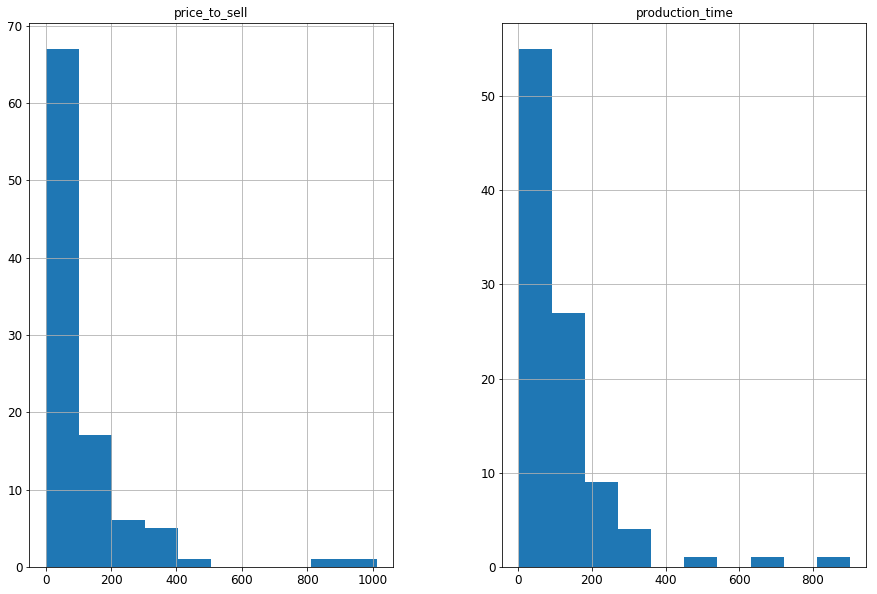

In [24]:
products[['production_time', 'price_to_sell']].hist()

Распределения характеристик price_to_sell и production_time у продуктов практически одинаковые, средние значения близкие, 124.918 для production_time и 106.250 для price_to_sell. При этом значения коэффициентов при этих переменных в модели сильно различаются: 0.1624 для price_to_sell и 0.0270 для production_time.

Из этого можно сделать вывод, что цена продажи в амбаре оказывает значительно более сильное влияние на решение игрока удалить заказ, чем время производства или роста, если быть точным, в 5.12 раз более сильное (расчет см. ниже).

In [25]:
(106.250*0.1624)/(124.918*0.0270)

5.1159486549102136

Построенная модель объясняет 43% вариации моделируемого показателя, вероятно, есть и другие важные факторы, влияющие на склонность игрока удалять заказы с данным продуктом, данные по которым не были собраны. Например, это может быть стоимость объектов, которые нужно последовательно построить для производства данного продукта.